# <span style="color:blue"> MBA em Ciência de Dados</span>
# <span style="color:blue">Aprendizado Dinâmico</span>

## <span style="color:blue">Avaliação Final</span>

### Aluno: Benicio Ramos Magalhães

**Material Produzido por Cibele Russo**<br>
**Cemeai - ICMC/USP São Carlos**

##### Para esta avaliação, você deve entregar três arquivos:
    ● um arquivo de dados em .csv com a base resultante das análises
    ● um relatório em .ipynb com suas análises comentadas
    ● um arquivo .pdf gerado a partir do .ipynb

##### Os dados de casos confirmados e mortes diárias por COVID-19 nos Estados Unidos estão disponíveis no arquivo covid19USA.csv. 

In [174]:
#bibliotecas
import six
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
from keras.layers import LSTM
from keras.layers import Dense
from pmdarima import auto_arima
from keras.models import Sequential
sys.modules['sklearn.externals.six'] = six
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
import warnings; warnings.simplefilter('ignore')
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Exercício 1

#### Você deve fazer a leitura dos dados, estabelecer um índice por datas, verificar se os dados estão corretos e realizar algum procedimento necessário caso haja dados faltantes. 

In [2]:
#leitura dos dados estabelecendo um índice por datas
data = pd.read_csv('.\covid19USA.csv',index_col='date',parse_dates=True)
data.head()

confirmed  deaths
date                         
2020-01-01          0       0
2020-01-02          0       0
2020-01-03          0       0
2020-01-04          0       0
2020-01-05          0       0

 ___________________________________________________________
|                    Verificação de dados                   |
|___________________________________________________________|
|Início:----------------------------| 2020-01-01 00:00:00 --|
|Fim:-------------------------------| 2020-09-03 00:00:00 --|
|Tipo de dado do índice:------------| datetime64[ns] -------|
|Tamanho da base original:----------| 247 ------------------|
|Tamanho esperado para o intervalo:-| 247 ------------------|
|Dados Faltantes em confirmed:------| 0 --------------------|
|Dados Faltantes em deaths:---------| 0 --------------------|
|___________________________________________________________|


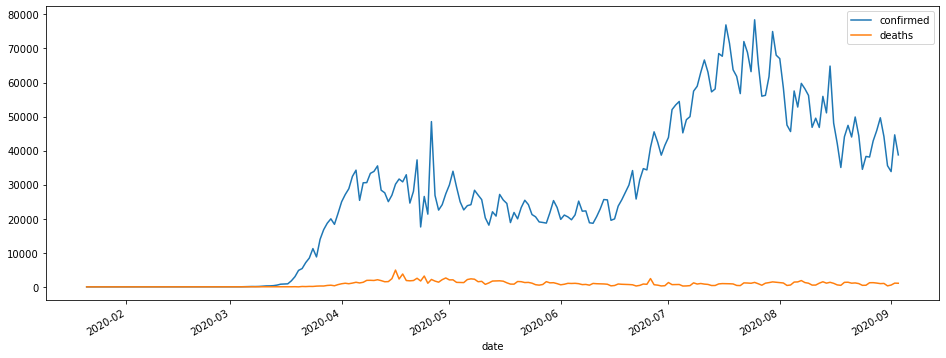

In [3]:
#verificando se os dados estão corretos

#checando intervalos de datas e tamanho do da base:
print(' ___________________________________________________________')
print('|                    Verificação de dados                   |')
print('|___________________________________________________________|')
print('|Início:----------------------------|',data.index.min(),'--|')
print('|Fim:-------------------------------|',data.index.max(),'--|')
print('|Tipo de dado do índice:------------|',data.index.dtype,'-------|')
print('|Tamanho da base original:----------|',len(data),'------------------|')
print('|Tamanho esperado para o intervalo:-|',len(pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')),'------------------|')

#verifcando se temos dados faltantes:
print('|Dados Faltantes em confirmed:------|',len(data[data['confirmed'].isnull()]),'--------------------|')
print('|Dados Faltantes em deaths:---------|',len(data[data['deaths'].isnull()]),'--------------------|')
print('|___________________________________________________________|')

#printando os dados:
rcParams['figure.figsize'] = 16, 6
data[data['confirmed']>0].plot();

    Conforme observamos na base de dados, não verificamos necessidade de aplicar algum procedimento para dados faltantes.

### Exercício 2

#### Proponha uma decomposição dos dados de mortes em tendência e sazonalidade. Obtenha os gráficos de autocorrelação e autocorrelação parcial. Comente brevemente os resultados.

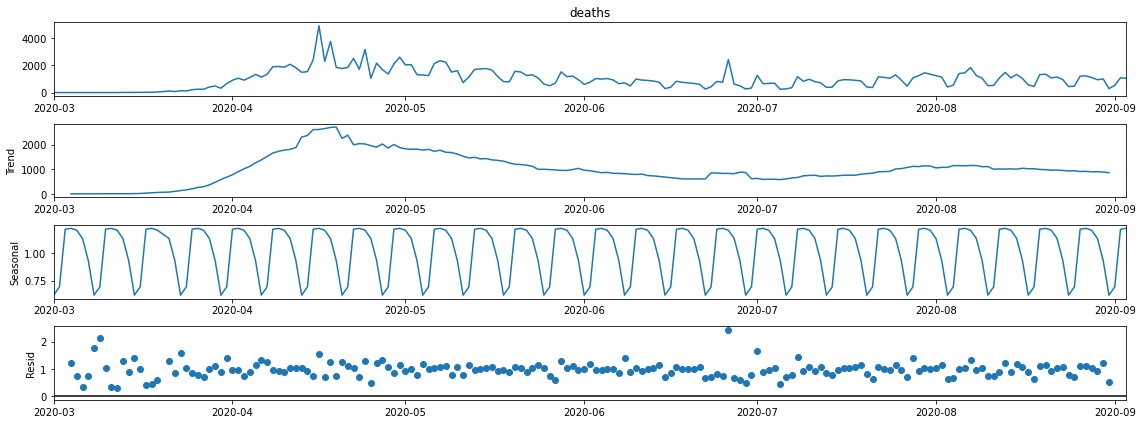

In [4]:
#decomposição dos dados de mortes em tendência e sazonalidade:
decomposicao = seasonal_decompose(data[data['deaths']>0]['deaths'],model='multiplicative', period=7)
fig = decomposicao.plot()

In [5]:
#testando a estacionariedade com Dickey-Fuller
result = adfuller(data['deaths'], autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.389673
p-value: 0.144672
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.574


###### Análise de tendência:
        É possível observar uma tendência crescente no período de abril. A curva segue depois com uma tendência decrescente até meados de junho. No final de junho, temos um pequeno período de elevação, seguido logo de queda. Depois desse período a tendência fica muito menos evidente, praticamente sugerindo uma estacionaridade, porém, como os testes de Dickey-Fuller realizados anteriormente com p-valor maior que 0.05, rejeitamos a hipótese de estacionariedade na série.

###### Análise de sazonalidade:
        Podemos observar ciclos semanais que provavelmente são explicadas pela sistemática de notificações, onde os dados ficam acumulados para cálculo no ínicio da semana e são sumarizados e apresentados mais para o meio da semana. Com relação ao tipo de sazonalidade, o gráfico apresenta algumas variações ao longo da série temporal, principalmente nos períodos de tendência crescente, portanto, consideramos mais adequada representarmos a sazonalidade como sendo do tipo multiplicativa.

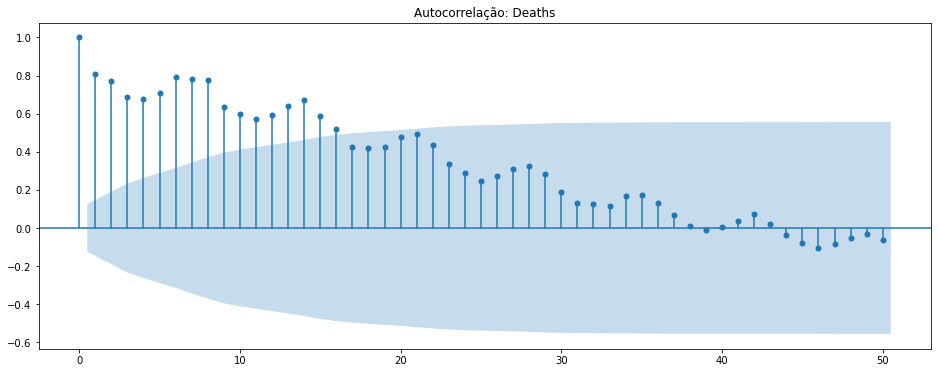

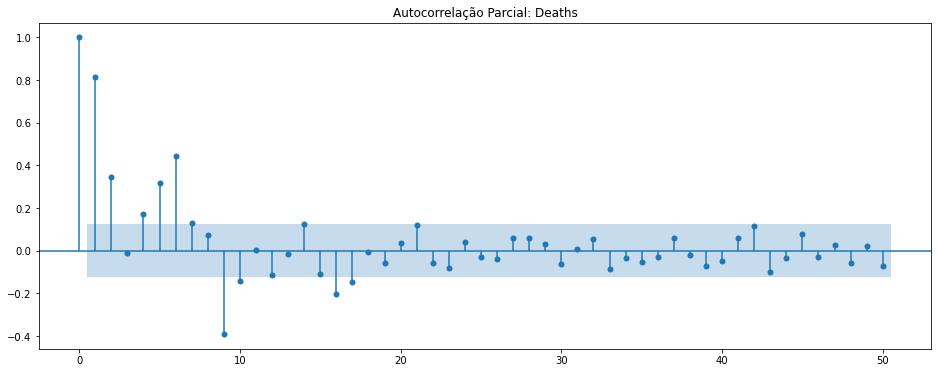

In [6]:
#gráficos de autocorrelação e autocorrelação parcial
fig = plot_acf(data['deaths'],title='Autocorrelação: Deaths',lags=50)
fig = plot_pacf(data['deaths'],title='Autocorrelação Parcial: Deaths',lags=50)

###### Análise de autocorrelação:
        Podemos observar que a correlação entre a série original até a série com atraso lag=16 são bastante significativas pois encontram-se maiores que o intervalo de confiança (área azul), portanto, precisamos levá-las em consideração durante a modelagem. Notamos também que há presença de sazonalidade nos dados, apresentando vales e picos em ciclos de 7 dias.
        
###### Análise de autocorrelação parcial:  
        Podemos verificar que a partir do lag=3 a correlação cai bastante, apresentando valores por volta 0.4. Mesmo as correlações não sendo tão altas, elas ainda são importantes para o modelo, pois apresentam-se fora do intervalo de confiança.

### Exercício 3

#### Divida a base em treino e teste, com 21 observações na base de teste. Você deverá apresentar em distintas colunas na mesma base de dados que será entregue: 

          ● Os dados originais de casos confirmados e mortes. 
    
          ● As previsões de Holt e Holt Winters para a variável mortes. 
    
          ● As previsões obtidas pelo melhor modelo SARIMA, com ordens selecionadas segundo critério preestabelecido para a variável mortes. Identifique as componentes desse melhor modelo (por exemplo, “o modelo tem uma componente autorregressiva não sazonal de ordem.., uma componente de médias móveis não-sazonal de ordem.., etc). 
    
          ● As previsões obtidas por um modelo de redes dinâmicas para a variável mortes. 

In [7]:
#definindo uma semente (42! - the answer to everything)
np.random.seed(42)

#dividindo a base em treino e teste:
train = data.iloc[:226]
test = data.iloc[226:]

print('Base de treino:',len(train),'observações.')
print('Base de teste:',len(test),'observações.')

Base de treino: 226 observações.
Base de teste: 21 observações.


In [8]:
#métodos de suavização holt e holt-winters para a variável mortes:

#treinamento e predição pelo método de Holt
adjustH = ExponentialSmoothing(train['deaths'],trend='add').fit()
predictH = adjustH.forecast(21).rename('Previsão Holt')
predictH.index = data.index[226:]

#treinamento e predição pelo método de Holt-Winters
adjustHW = ExponentialSmoothing(train['deaths'],trend='add',seasonal='add',seasonal_periods=7).fit()
predictHW = adjustHW.forecast(21).rename('Previsão Holt-Winters')
predictHW.index = data.index[226:]

            confirmed  deaths       holt  holt-winters
date                                                  
2020-01-01          0       0   8.383989      8.177887
2020-01-02          0       0  10.737133     10.468893
2020-01-03          0       0  12.356743     12.166760
2020-01-04          0       0  13.471327     13.371696
2020-01-05          0       0  14.238206     14.261848


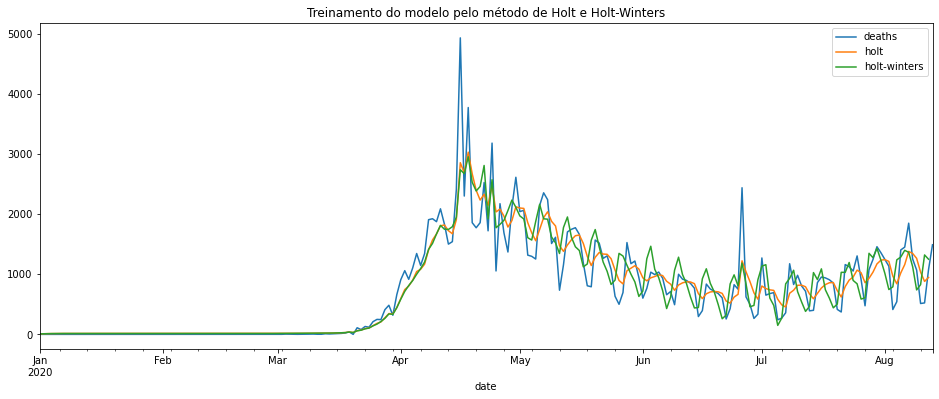

In [9]:
#imprimindo dados de treinamento modelados pelo método de holt e holt-winters
train['holt'] = adjustH.fittedvalues.shift(-1);
train['holt-winters'] = adjustHW.fittedvalues.shift(-1);
print(train.head())
fig = train[['deaths','holt','holt-winters']].plot(figsize=(16,6),
                                                   title='Treinamento do modelo pelo método de Holt e Holt-Winters')

In [10]:
#imprimindo dados com a predição realizada pelo método de holt e holt-winters
test['holt'] = predictH
test['holt-winters'] = predictHW
print(test.head())
train['deaths'].plot(legend=True,label='Treino',title='Predição do modelo pelo método de Holt e Holt-Winters')
test['deaths'].plot(legend=True,label='Teste',figsize=(16,6))
predictH.plot(legend=True,label='Previsão Holt')
fig = predictHW.plot(legend=True,label='Previsão Holt-Winters')

            confirmed  deaths         holt  holt-winters
date                                                    
2020-08-14      51094    1083  1120.581342   1425.505533
2020-08-15      64838    1336  1125.546155   1178.708462
2020-08-16      48085    1035  1130.510968    980.247421
2020-08-17      42104     571  1135.475780    585.397064
2020-08-18      35056     445  1140.440593    726.522397


In [11]:
# aplicando stepwise para selecionar o melhor modelo SARIMA
auto_arima(train['deaths'],seasonal=True,m=7).summary()

stepwise_fit = auto_arima(train['deaths'], start_p=0, start_q=0,max_p=6,max_q=3,m=7,
                          seasonal=True,
                          trace=True,
                          error_action='ignore',
                          supress_warnings=True,
                          stepwise=True)

stepwise_fit.summary()

Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 1, 7); AIC=3418.337, BIC=3432.001, Fit time=0.141 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 7); AIC=3418.463, BIC=3425.295, Fit time=0.016 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 7); AIC=3353.998, BIC=3367.663, Fit time=0.228 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=3349.966, BIC=3363.630, Fit time=0.325 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 1, 7); AIC=3306.510, BIC=3323.591, Fit time=0.739 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 0, 7); AIC=3340.881, BIC=3354.546, Fit time=0.270 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 2, 7); AIC=3304.675, BIC=3325.171, Fit time=1.201 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 2, 7); AIC=3300.207, BIC=3324.120, Fit time=1.329 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 2, 7); AIC=3306.376, BIC=3326.873, Fit time=1.147 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_o

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  226
Model:             SARIMAX(3, 1, 3)x(1, 0, [], 7)   Log Likelihood               -1633.119
Date:                            Sun, 13 Sep 2020   AIC                           3284.239
Time:                                    20:52:02   BIC                           3314.984
Sample:                                         0   HQIC                          3296.648
                                            - 226                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -5.6011     14.299     -0.392      0.695     -33.626      22.424
ar.L1          0.8173      0.071     11.520      0.000       0.678       0.956
ar.L2         -0.4568      0.089     -5.133      0.000      -0.631      -0.282
ar.L3         -0.4185      0.064     -6.533      0.000      -0.544      -0.293
ma.L1         -1.5598      0.080    -19.531      0.000      -1.716      -1.403
ma.L2          1.2980      0.113     11.448      0.000       1.076       1.520
ma.L3         -0.3483      0.074     -4.689      0.000      -0.494      -0.203
ar.S.L7       -0.0497      0.056     -0.881      0.378      -0.160       0.061
sigma2      1.318e+05   5703.856     23.108      0.000    1.21e+05    1.43e+05
===================================================================================
Ljung-Box (Q):                       51.68   Jarque-Bera (JB):              6750.13
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):             464.93   Skew:                             2.99
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

###### Descrição do modelo selecionado: SARIMAX(3, 1, 3)x(1, 0, 0, 7)

    - Componente não sazonal autorregressiva de ordem 3
    - Componente não sazonal integrado de ordem 1
    - Componente não sazonal de médias móveis de ordem 3
    - Componente sazonal autorregressiva de primeira ordem com período 7
    - Sem componente sazonal integrada
    - Sem componente sazonal de média móvel

In [12]:
#treinamento utilizando o modelo SARIMA identificado pelo stepwise
adjustSARIMA = SARIMAX(train['deaths'],order=(3,1,3),seasonal_order=(1,0,0,7)).fit()
adjustSARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             deaths   No. Observations:                  226
Model:             SARIMAX(3, 1, 3)x(1, 0, [], 7)   Log Likelihood               -1631.614
Date:                            Sun, 13 Sep 2020   AIC                           3279.228
Time:                                    20:52:04   BIC                           3306.557
Sample:                                01-01-2020   HQIC                          3290.258
                                     - 08-13-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8179      0.063     13.040      0.000       0.695       0.941
ar.L2         -0.4578      0.079     -5.788      0.000      -0.613      -0.303
ar.L3         -0.4142      0.056     -7.403      0.000      -0.524      -0.305
ma.L1         -1.5655      0.071    -22.156      0.000      -1.704      -1.427
ma.L2          1.2993      0.102     12.737      0.000       1.099       1.499
ma.L3         -0.3508      0.066     -5.313      0.000      -0.480      -0.221
ar.S.L7       -0.0502      0.045     -1.126      0.260      -0.138       0.037
sigma2      1.151e+05   3894.620     29.560      0.000    1.07e+05    1.23e+05
===================================================================================
Ljung-Box (Q):                       51.51   Jarque-Bera (JB):              6746.95
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):           54463.55   Skew:                             3.00
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
#predição utilizando o modelo SARIMA identificado pelo stepwise
start = len(train)
end = len(train) + len(test)-1
predict_SARIMA = adjustSARIMA.predict(start=start,end=end,
                                      dynamic=False,typ='levels').rename('Previsões SARIMA(3, 1, 3)x(1, 0, 0, 7)')
predict_SARIMA.index = test.index

date
2020-08-14    1493.331715
2020-08-15    1300.243922
2020-08-16     883.135011
2020-08-17     654.833988
2020-08-18     732.306818
Name: Previsões SARIMA(3, 1, 3)x(1, 0, 0, 7), dtype: float64


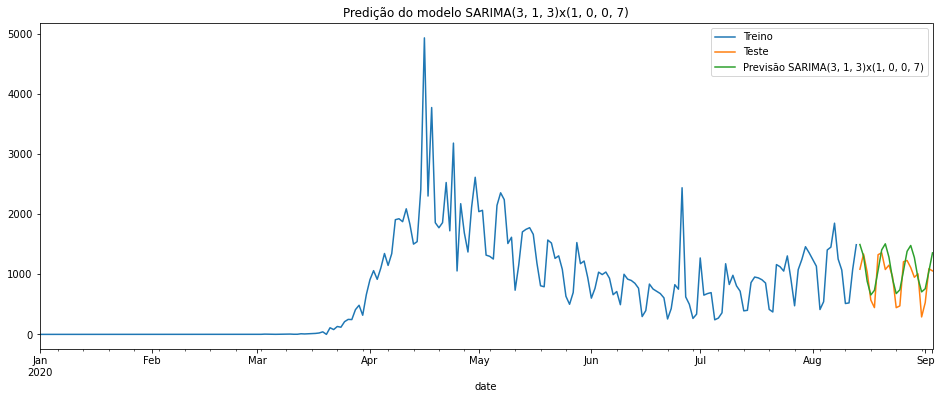

In [14]:
#imprimindo dados com a predição realizada pelo SARIMA
train['sarima'] = adjustSARIMA.fittedvalues
test['sarima'] = predict_SARIMA
print(predict_SARIMA.head())
train['deaths'].plot(legend=True,label='Treino',title='Predição do modelo SARIMA(3, 1, 3)x(1, 0, 0, 7)')
test['deaths'].plot(legend=True,label='Teste',figsize=(16,6))
fig = predict_SARIMA.plot(legend=True,label='Previsão SARIMA(3, 1, 3)x(1, 0, 0, 7)')

In [15]:
# padronizando os dados para aplicar modelo de redes dinâmicas
scaler = MinMaxScaler().fit(train['deaths'].values.reshape(-1,1))
scaled_train = scaler.transform(train['deaths'].values.reshape(-1,1))
scaled_test = scaler.transform(test['deaths'].values.reshape(-1,1))

print(' ____________________________________________________________________________')
print('|Intervalo de dados de treino:  |',scaled_train.min(),' - ',scaled_train.max(),'                               |')
print('|____________________________________________________________________________|')
print('|Intervalo de dados de teste:   |',scaled_test.min(),' - ',scaled_test.max(),'|')
print('|____________________________________________________________________________|')

fig = plt.hist(scaled_train)

 ____________________________________________________________________________
|Intervalo de dados de treino:  | 0.0  -  1.0                                |
|____________________________________________________________________________|
|Intervalo de dados de teste:   | 0.0588474025974026  -  0.27516233766233766 |
|____________________________________________________________________________|


In [16]:
#definindo o gerador
generator = TimeseriesGenerator(scaled_train, scaled_train, length=7, batch_size=1) #lote de tamanho 7 devido a sazonalidade

print('Tamanho das amostras de treino:',len(scaled_train))
print('Tamanho do gerador dividido por lotes:',len(generator))

X,y = generator[0] #aparência do primeiro lote

print()
print('Dados do primeiro lote:',X.flatten())
print('Predição do primeiro lote:',y.flatten())

Tamanho das amostras de treino: 226
Tamanho do gerador dividido por lotes: 219

Dados do primeiro lote: [0. 0. 0. 0. 0. 0. 0.]
Predição do primeiro lote: [0.]


In [17]:
#modelo de redes dinâmicas LSTM (Long Short-Term Memory)
model = Sequential()
model.add(LSTM(100, activation='relu',input_shape=(7,1))) #camada LSTM com 100 neurônios
model.add(Dense(1)) #camada de saída com 1 output
model.compile(optimizer='adam',loss='mse') #função de perda de erro quadrático médio
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [18]:
#ajustando o modelo
model.fit_generator(generator, epochs=100) #com 100 interações

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
219/219 [==============================] - 1s 3ms/step - loss: 0.0140
Epoch 2/100
219/219 [==============================] - 1s 3ms/step - loss: 0.0085
Epoch 3/100
219/219 [==============================] - 1s 3ms/step - loss: 0.0082
Epoch 4/100
219/219 [==============================] - 1s 3ms/step - loss: 0.0079
Epoch 5/100
219/219 [==============================] - 1s 4ms/step - loss: 0.0085
Epoch 6/100
219/219 [==============================] - 1s 3ms/step - loss: 0.0075
Epoch 7/100
219/219 [==============================] - 1s 3ms/step - loss: 0.0075
Epoch 8/100
219/219 [==============================] - 1s 4ms/step - loss: 0.0077
Epoch 9/100
219/219 [==============================] - 1s 3ms/step - loss: 0.0074
Epoch 10/100
219/219 [==============================] - 1s 3ms/step - loss: 0.0074
Epoch 11/100
219/219 [==============================] - 1s 3ms/step - loss: 0.0076
Epoch 12/100
219/219

219/219 [==============================] - 1s 4ms/step - loss: 0.0036
Epoch 97/100
219/219 [==============================] - 1s 3ms/step - loss: 0.0034
Epoch 98/100
219/219 [==============================] - 1s 4ms/step - loss: 0.0037
Epoch 99/100
219/219 [==============================] - 1s 3ms/step - loss: 0.0035
Epoch 100/100
219/219 [==============================] - 1s 3ms/step - loss: 0.0037


In [19]:
#salvando o modelo gerado
model.save('modelo_rnn_lstm.h5') 
model.history.history.keys()

dict_keys(['loss'])

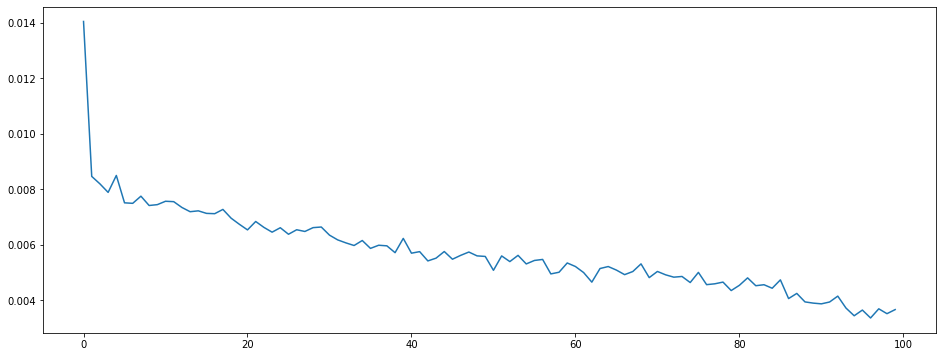

In [20]:
#plotando um gráfico de perda, resultante das iterações do ajuste do modelo
loss_per_epoch = model.history.history['loss']
fig = plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [21]:
#realizando a previsão com os dados de teste
test_predictions = []
first_batch = scaled_train[-7:]
current_batch = first_batch.reshape((1,7,1))

for i in range(len(test)):
    current_prediction = model.predict(current_batch)[0]
    test_predictions.append(current_prediction)
    current_batch = np.append(current_batch[:,1:,:],[[current_prediction]],axis=1)

In [22]:
#voltando a padronização dos dados para treino e para as predições dos testes
train_model = scaler.inverse_transform(scaled_train)
true_predictions = scaler.inverse_transform(test_predictions)

date
2020-08-14    1429.379177
2020-08-15    1261.947414
2020-08-16     889.416251
2020-08-17     535.796268
2020-08-18     469.557900
Name: lstm, dtype: float64


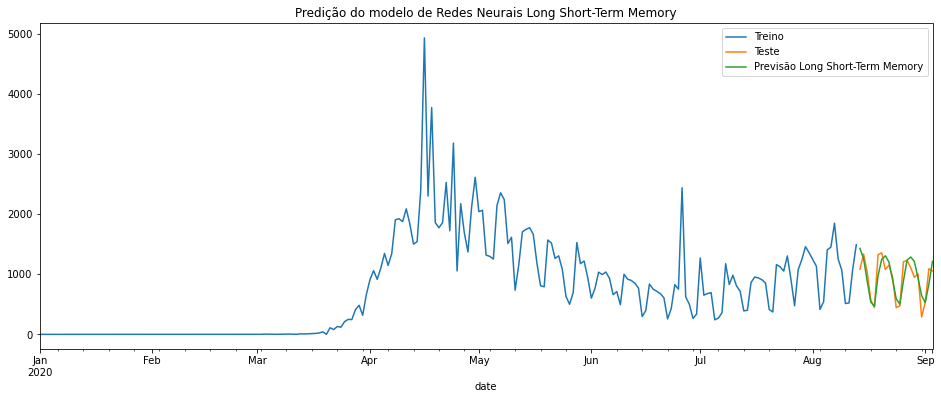

In [23]:
#imprimindo dados com a predição realizada pelas redes dinâmicas lstm
train['lstm'] = train_model #copiando a mesma base de treino na previsão LSTM para evitar deixar tudo vazio.
test['lstm'] = true_predictions
print(test['lstm'].head())
train['deaths'].plot(legend=True,label='Treino',title='Predição do modelo de Redes Neurais Long Short-Term Memory')
test['deaths'].plot(legend=True,label='Teste',figsize=(16,6))
fig = test['lstm'].plot(legend=True,label='Previsão Long Short-Term Memory')

In [24]:
#printando os resultados em um arquivo csv
data_csv = pd.concat([train, test])
data_csv.to_csv('Benicio-avaliacao-ad-resultados-analises.csv')

### Exercício 4

#### Utilize o erro quadrático médio e erro absoluto médio para comparar as previsões obtidas com as observações da base de teste.

In [29]:
#utilizando erro quadrático médio e erro absoluto médio para comparação 

#comparação entre modelos usando MSE
print('  _____________________________________________')
print(' |               Avalição MSE                  |')
print(' | ____________________________________________|')
print(' | HOLT:                           |', '%.2f' % mean_squared_error(test['deaths'],test['holt']),'|')
print(' | HOLT-WINTERS:                   |','%.2f' % mean_squared_error(test['deaths'],test['holt-winters']),' |')
print(' | SARIMA(3, 1, 3)x(1, 0, 0, 7):   |','%.2f' % mean_squared_error(test['deaths'],test['sarima']),' |')
print(' | LSTM:                           |','%.2f' % mean_squared_error(test['deaths'],test['lstm']),' |')
print(' |_________________________________|___________|')
print()
print()
#comparação entre modelos usando MAE
print('  _____________________________________________')
print(' |               Avalição MAE                  |')
print(' | ____________________________________________|')
print(' | HOLT:                           |','%.2f' % mean_absolute_error(test['deaths'],test['holt']),'   |')
print(' | HOLT-WINTERS:                   |','%.2f' % mean_absolute_error(test['deaths'],test['holt-winters']),'   |')
print(' | SARIMA(3, 1, 3)x(1, 0, 0, 7):   |','%.2f' % mean_absolute_error(test['deaths'],test['sarima']),'   |')
print(' | LSTM:                           |','%.2f' % mean_absolute_error(test['deaths'],test['lstm']),'   |')
print(' |_________________________________|___________|')

  _____________________________________________
 |               Avalição MSE                  |
 | ____________________________________________|
 | HOLT:                           | 164390.59 |
 | HOLT-WINTERS:                   | 56520.76  |
 | SARIMA(3, 1, 3)x(1, 0, 0, 7):   | 61597.01  |
 | LSTM:                           | 37317.54  |
 |_________________________________|___________|


  _____________________________________________
 |               Avalição MAE                  |
 | ____________________________________________|
 | HOLT:                           | 294.60    |
 | HOLT-WINTERS:                   | 196.27    |
 | SARIMA(3, 1, 3)x(1, 0, 0, 7):   | 211.41    |
 | LSTM:                           | 151.82    |
 |_________________________________|___________|


Temos as seguintes definições para MSE e MAE:

###### MSE (Mean Square Error):
$$
{MSE} = {{1 \over N}  \sum_{i=1}^N{(y_i - \hat{y_i})^2}}
$$

###### MAE (Mean Absolute Error):
$$
{MAE} = {{1 \over N}  \sum_{i=1}^N{|y_i - \hat{y_i}|}}
$$

onde 
   
   ${y_i}$ = valor real da variável dependente
   
   $\hat{y_i}$ = valor previsto
   
   ${N}$ = tamanho da amostra
   
   
Essas medidas são bem diretas, sendo basicamente uma somatória da diferença entre o valor real e o valor previsto. Isso mostra o quanto nossos resultados previstos divergem do valor real. Um MSE mais alto significa que os valores estão muito dispersos, portanto, quanto menor o valor desta métrica, melhor, refletindo assim em um bom ajuste do modelo. Um ponto de atenção que devemos ter é que valores muito pequenos para MSE podem indicar um overfitting dos dados.

Neste caso, para avaliarmos o melhor modelo, estamos comparando os valores obtidos e dando preferência para a avaliação onde tivemos o menor valor, tanto no MSE quanto no MAE. Assim, o modelo com a melhor previsão foi de <b>RNN Long Short-Term Memory</b>.

### Exercício 5

#### Considere o método que produziu a melhor previsão para os dados de teste e faça a previsão para mais 14 dias (além das observações da base de dados). Essa previsão pode ser apresentada com um gráfico nos arquivos .ipynb e .pdf. 

In [171]:
# padronizando os dados para aplicar modelo de redes dinâmicas
scaler = MinMaxScaler().fit(data['deaths'].values.reshape(-1,1))
scaled_data = scaler.transform(data['deaths'].values.reshape(-1,1))

#definindo o gerador
generator = TimeseriesGenerator(scaled_data, scaled_data, length=7, batch_size=1) #lote de tamanho 7 devido a sazonalidade

#modelo de redes dinâmicas LSTM (Long Short-Term Memory)
model = Sequential()
model.add(LSTM(100, activation='relu',input_shape=(7,1))) #camada LSTM com 100 neurônios
model.add(Dense(1)) #camada de saída com 1 output
model.compile(optimizer='adam',loss='mse') #função de perda de erro quadrático médio

#ajustando o modelo
model.fit_generator(generator, epochs=100) #com 100 interações

#realizando a previsão com os dados de teste
test_predictions = []
first_batch = scaled_train[-7:]
current_batch = first_batch.reshape((1,7,1))

for i in range(14): #próximos 14 dias
    current_prediction = model.predict(current_batch)[0]
    test_predictions.append(current_prediction)
    current_batch = np.append(current_batch[:,1:,:],[[current_prediction]],axis=1)
    
#voltando a padronização dos dados para treino e para as predições dos testes
data_model = scaler.inverse_transform(scaled_data)
data_true_predictions = scaler.inverse_transform(test_predictions)

Epoch 1/100
240/240 [==============================] - 1s 3ms/step - loss: 0.0097
Epoch 2/100
240/240 [==============================] - 1s 3ms/step - loss: 0.0079
Epoch 3/100
240/240 [==============================] - 1s 3ms/step - loss: 0.0084
Epoch 4/100
240/240 [==============================] - 1s 4ms/step - loss: 0.0080
Epoch 5/100
240/240 [==============================] - 1s 4ms/step - loss: 0.0084
Epoch 6/100
240/240 [==============================] - 1s 3ms/step - loss: 0.0080
Epoch 7/100
240/240 [==============================] - 1s 3ms/step - loss: 0.0074
Epoch 8/100
240/240 [==============================] - 1s 3ms/step - loss: 0.0073
Epoch 9/100
240/240 [==============================] - 1s 3ms/step - loss: 0.0073
Epoch 10/100
240/240 [==============================] - 1s 3ms/step - loss: 0.0075
Epoch 11/100
240/240 [==============================] - 1s 3ms/step - loss: 0.0069
Epoch 12/100
240/240 [==============================] - 1s 3ms/step - loss: 0.0069
Epoch 13/100


240/240 [==============================] - 1s 3ms/step - loss: 0.0037
Epoch 100/100
240/240 [==============================] - 1s 3ms/step - loss: 0.0032


In [172]:
#armazenando os dados e indexando
data_forecast = pd.DataFrame(data_true_predictions,columns=['deaths'])
data_forecast.index = pd.date_range(start='2020-09-04',end='2020-09-17')

2020-09-04    1246.683060
2020-09-05    1219.439445
2020-09-06     983.194205
2020-09-07     441.793830
2020-09-08     395.007989
2020-09-09     918.416087
2020-09-10    1091.325285
2020-09-11    1156.796830
2020-09-12    1108.891027
2020-09-13     951.661154
2020-09-14     585.273389
2020-09-15     470.535292
2020-09-16     802.235070
2020-09-17    1107.128270
Freq: D, Name: deaths, dtype: float64


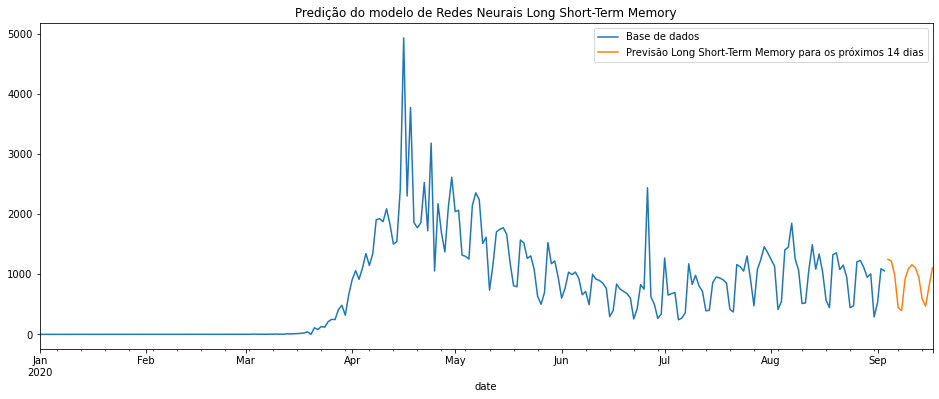

In [173]:
#imprimindo dados com a predição realizada pelas redes dinâmicas lstm - 14 dias
print(data_forecast['deaths'])
data['deaths'].plot(legend=True,label='Base de dados',title='Predição do modelo de Redes Neurais Long Short-Term Memory')
fig = data_forecast['deaths'].plot(legend=True,label='Previsão Long Short-Term Memory para os próximos 14 dias')